In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cardekho-used-car-data/cardekho_dataset.csv


In [86]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [88]:
##### 📌 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import optuna

# 📌 2. Load Dataset
df = pd.read_csv('/kaggle/input/cardekho-used-car-data/cardekho_dataset.csv')

# 📌 3. Rename Columns
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# 📌 4. Drop Unnecessary Columns
if 'car_name' in df.columns:
    df.drop('car_name', axis=1, inplace=True)

# 📌 5. Clean Numeric Columns
for col in ['mileage', 'engine', 'max_power']:
    df[col] = df[col].astype(str).str.extract(r'(\d+\.\d+|\d+)').astype(float)

# 📌 6. Drop Missing Rows
df.dropna(inplace=True)

# 📌 7. Remove Outliers
df = df[(df['selling_price'] > 50000) & (df['selling_price'] < 5000000)]
df = df[df['km_driven'] < df['km_driven'].quantile(0.99)]
df = df[df['max_power'] < df['max_power'].quantile(0.99)]
df = df[df['mileage'] < df['mileage'].quantile(0.99)]

# 📌 8. Feature Engineering
df['log_km'] = np.log1p(df['km_driven'])
df['log_engine'] = np.log1p(df['engine'])
df['power_to_engine'] = df['max_power'] / (df['engine'] + 1)
df['price_per_km'] = df['selling_price'] / (df['km_driven'] + 1)
df['log_price'] = np.log1p(df['selling_price'])

# 📌 9. Encode Categorical Columns
cat_cols = ['brand', 'model', 'seller_type', 'fuel_type', 'transmission_type']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# 📌 10. Train/Test Split
X = df.drop(['selling_price', 'log_price'], axis=1)
y = df['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📌 11. Optuna Objective Function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42,
        'tree_method': 'hist',  # Faster for large datasets
        'verbosity': 0
    }

    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    return mae

# 📌 12. Run Optuna Study
study = optuna.create_study(direction='minimize', study_name="XGBoost Tuning")
study.optimize(objective, n_trials=50, timeout=1200)  # 50 trials or 20 minutes

# 📌 13. Best Hyperparameters
print("✅ Best Parameters Found by Optuna:")
print(study.best_params)

# 📌 14. Train Final Model with Best Params
best_params = study.best_params
best_params['random_state'] = 42
best_params['tree_method'] = 'hist'
best_params['verbosity'] = 0

final_model = XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

# 📌 15. Evaluate Model
preds = final_model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"\n📉 Final MAE: {mae:.2f}")
print(f"📈 Final R² Score: {r2:.4f}")


[I 2025-04-10 23:21:35,102] A new study created in memory with name: XGBoost Tuning
[I 2025-04-10 23:21:42,283] Trial 0 finished with value: 0.03681005082807725 and parameters: {'n_estimators': 956, 'max_depth': 13, 'learning_rate': 0.2770766035592607, 'subsample': 0.7041761464486951, 'colsample_bytree': 0.6785671062318062, 'reg_alpha': 0.24082318111451995, 'reg_lambda': 0.8666742125357684}. Best is trial 0 with value: 0.03681005082807725.
[I 2025-04-10 23:21:45,079] Trial 1 finished with value: 0.03093434042454234 and parameters: {'n_estimators': 525, 'max_depth': 7, 'learning_rate': 0.02063952996271393, 'subsample': 0.9363626996291259, 'colsample_bytree': 0.8925308977686253, 'reg_alpha': 0.03513277598988507, 'reg_lambda': 0.4321788422231111}. Best is trial 1 with value: 0.03093434042454234.
[I 2025-04-10 23:21:53,799] Trial 2 finished with value: 0.032278474281338024 and parameters: {'n_estimators': 555, 'max_depth': 15, 'learning_rate': 0.021324314400474997, 'subsample': 0.924130586

✅ Best Parameters Found by Optuna:
{'n_estimators': 901, 'max_depth': 6, 'learning_rate': 0.08547055326862296, 'subsample': 0.9578936387132087, 'colsample_bytree': 0.8614939977881569, 'reg_alpha': 0.09256128516022144, 'reg_lambda': 0.21407251691606935}

📉 Final MAE: 0.02
📈 Final R² Score: 0.9966


In [108]:
def preprocess_single_input(input_dict, trained_columns):
    df_input = pd.DataFrame([input_dict])

    # Clean numeric fields
    for col in ['mileage', 'engine', 'max_power']:
        df_input[col] = df_input[col].astype(str).str.extract(r'(\d+\.\d+|\d+)').astype(float)

    # Feature engineering
    df_input['log_km'] = np.log1p(df_input['km_driven'])
    df_input['log_engine'] = np.log1p(df_input['engine'])
    df_input['power_to_engine'] = df_input['max_power'] / (df_input['engine'] + 1)
    df_input['price_per_km'] = df_input['selling_price'] / (df_input['km_driven'] + 1)

    # One-hot encoding
    cat_cols = ['brand', 'model', 'seller_type', 'fuel_type', 'transmission_type']
    df_input = pd.get_dummies(df_input, columns=cat_cols, drop_first=True)

    # Align columns with training data
    df_input = df_input.reindex(columns=trained_columns, fill_value=0)

    return df_input


In [109]:
trained_columns = X_train.columns.tolist()


In [110]:
sample_input = {
    'year': 2017,
    'km_driven': 40000,
    'mileage': '20.0 kmpl',
    'engine': '1197 CC',
    'max_power': '82 bhp',
    'seats': 5,
    'selling_price': 400000,  # dummy, required for price_per_km calc
    'brand': 'Hyundai',
    'model': 'i20',
    'seller_type': 'Individual',
    'fuel_type': 'Petrol',
    'transmission_type': 'Manual'
}


In [111]:
# Preprocess input
processed_input = preprocess_single_input(sample_input, trained_columns)

# Predict log price and convert back
log_price_pred = final_model.predict(processed_input)[0]
predicted_price = round(np.expm1(log_price_pred), 2)

print(f"🚗 Predicted Selling Price: ₹{predicted_price}")


🚗 Predicted Selling Price: ₹400515.375


In [112]:
# Convert log_price predictions back to normal price
predicted_prices = np.expm1(preds)


In [113]:
comparison_df = pd.DataFrame({
    'Actual Price (₹)': np.expm1(y_test),
    'Predicted Price (₹)': predicted_prices
})

# Show top 10 predictions
comparison_df.head(10)


,Actual Price (₹),Predicted Price (₹)
15370,386000.0,3.908481e+05
10664,1575000.0,1.552325e+06
951,225000.0,2.234652e+05
6832,750000.0,7.466781e+05
14157,900000.0,9.045127e+05
927,350000.0,3.383352e+05
8006,319000.0,3.189672e+05
15065,550000.0,5.555922e+05
2436,795000.0,7.778187e+05
1476,450000.0,4.550787e+05


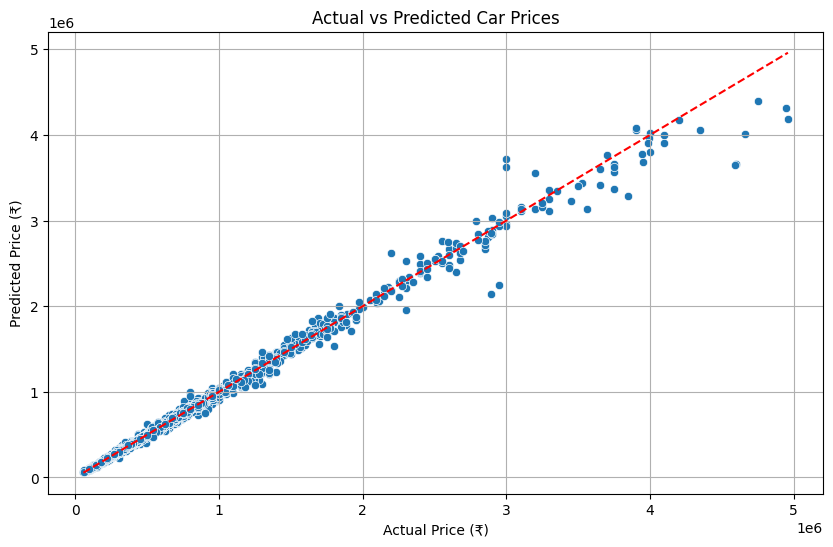

In [114]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=comparison_df['Actual Price (₹)'], y=comparison_df['Predicted Price (₹)'])
plt.plot([comparison_df.min().min(), comparison_df.max().max()],
         [comparison_df.min().min(), comparison_df.max().max()],
         '--', color='red')
plt.title("Actual vs Predicted Car Prices")
plt.xlabel("Actual Price (₹)")
plt.ylabel("Predicted Price (₹)")
plt.grid(True)
plt.show()


<Figure size 1200x800 with 0 Axes>

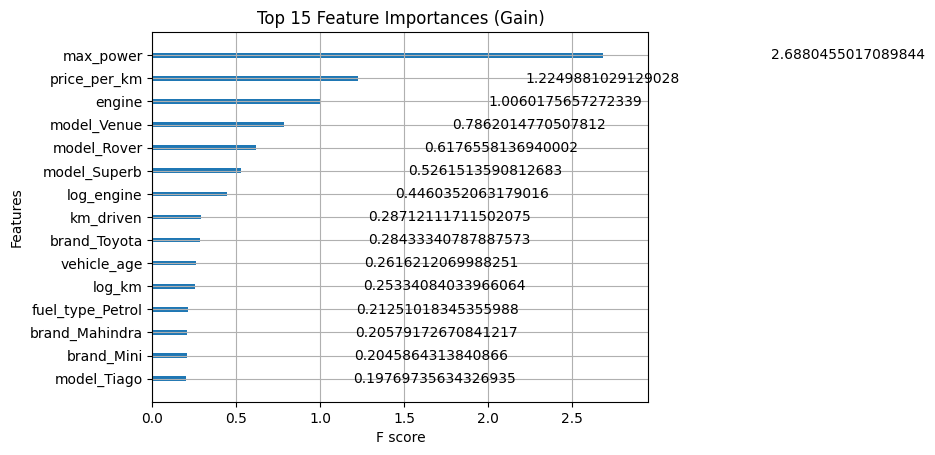

In [115]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance (based on gain)
plt.figure(figsize=(12, 8))
plot_importance(final_model, max_num_features=15, importance_type='gain')
plt.title("Top 15 Feature Importances (Gain)")
plt.show()



In [116]:
import joblib
joblib.dump(model, 'car_price_model1.pkl')

['car_price_model1.pkl']

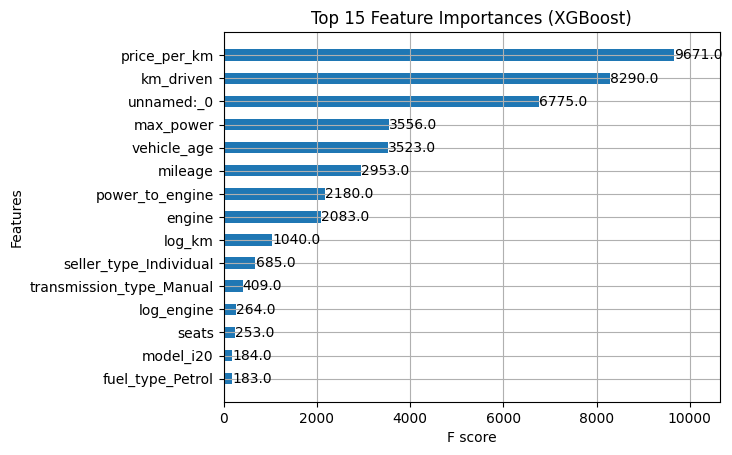

In [117]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(final_model, max_num_features=15, height=0.5)
plt.title('Top 15 Feature Importances (XGBoost)')
plt.show()


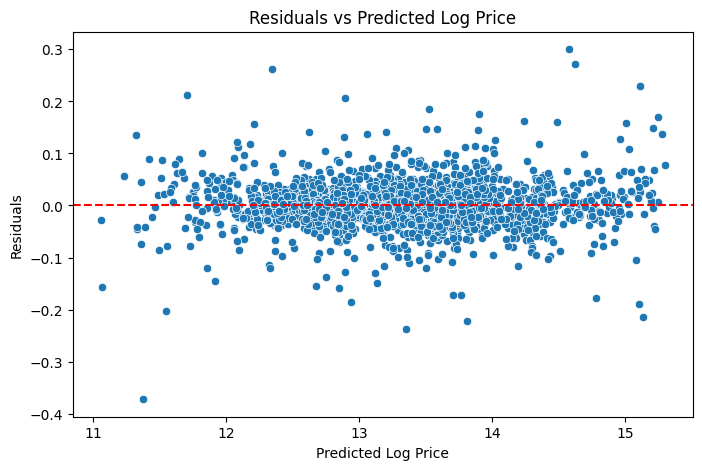

In [118]:
import seaborn as sns

residuals = y_test - preds

plt.figure(figsize=(8, 5))
sns.scatterplot(x=preds, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Log Price')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Log Price')
plt.show()


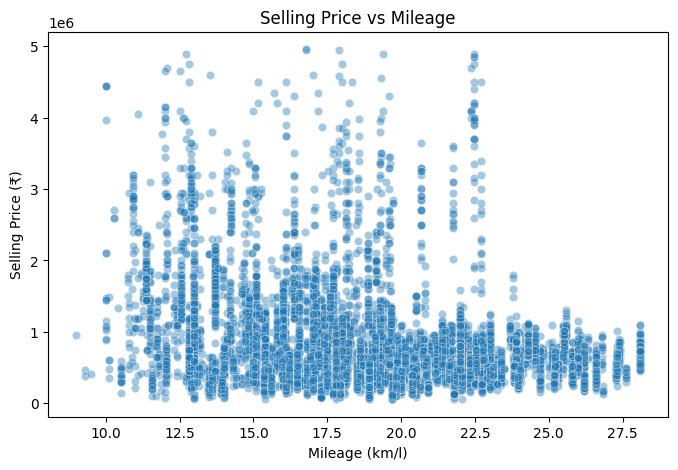

In [119]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['mileage'], y=df['selling_price'], alpha=0.4)
plt.xlabel('Mileage (km/l)')
plt.ylabel('Selling Price (₹)')
plt.title('Selling Price vs Mileage')
plt.show()


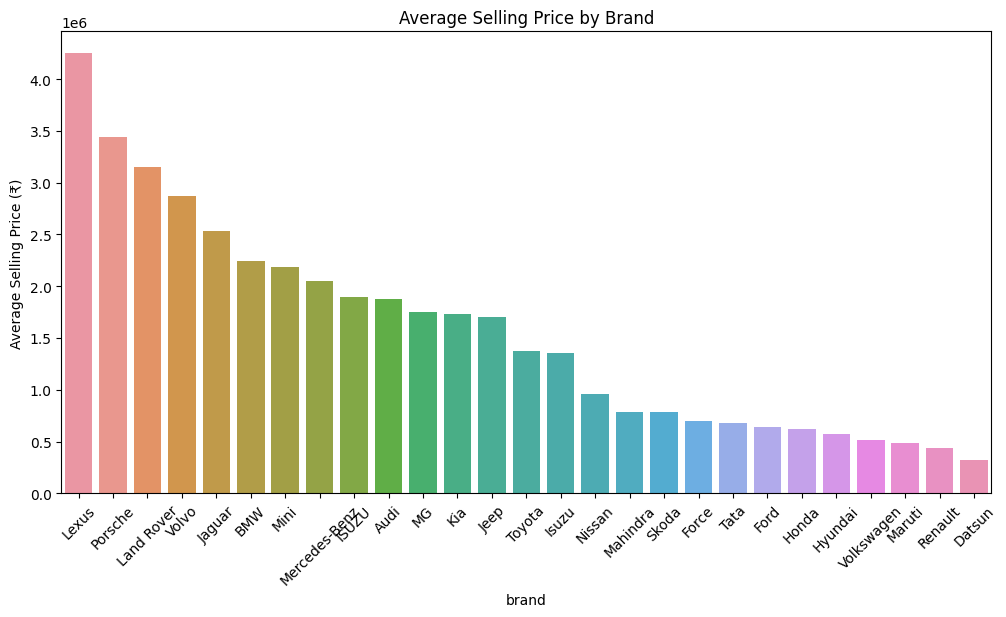

In [120]:
# First, get brand column back from the original CSV
df_raw = pd.read_csv('/kaggle/input/cardekho-used-car-data/cardekho_dataset.csv')
df_raw.columns = df_raw.columns.str.strip().str.lower().str.replace(' ', '_')

# Clean price and drop NAs for fair comparison
df_raw = df_raw[(df_raw['selling_price'] > 50000) & (df_raw['selling_price'] < 5000000)]
df_raw.dropna(subset=['selling_price', 'brand'], inplace=True)

plt.figure(figsize=(12, 6))
brand_avg = df_raw.groupby('brand')['selling_price'].mean().sort_values(ascending=False)
sns.barplot(x=brand_avg.index, y=brand_avg.values)
plt.xticks(rotation=45)
plt.ylabel('Average Selling Price (₹)')
plt.title('Average Selling Price by Brand')
plt.show()


In [127]:
def get_price_fairness(predicted_price, input_dict, df_raw):
    """
    Compares the predicted price to the average price of similar cars in the dataset.
    """

    # Extract matching conditions
    brand = input_dict['brand']
    model = input_dict['model']
    vehicle_age = input_dict['vehicle_age']

    # Filter similar cars in dataset
    similar_cars = df_raw[
        (df_raw['brand'] == brand) &
        (df_raw['model'] == model) &
        (df_raw['vehicle_age'] == vehicle_age)
    ]

    # Compute average price
    avg_price = similar_cars['selling_price'].mean()

    # Compare
    if np.isnan(avg_price):
        return "No Comparison"
    elif abs(predicted_price - avg_price) <= 0.1 * avg_price:
        return "✅ Fair Deal"
    elif predicted_price > avg_price:
        return "⚠️ Overpriced"
    else:
        return "💰 Underpriced"


In [129]:
sample_input = {
    'car_name': 'Hyundai i20',
    'brand': 'Hyundai',
    'model': 'i20',
    'vehicle_age': 5,       
    'km_driven': 45000,
    'seller_type': 'Dealer',
    'fuel_type': 'Petrol',
    'transmission_type': 'Manual',
    'mileage': '18.2 kmpl',
    'engine': '1197 CC',
    'max_power': '83.83 bhp',
    'selling_price': 450000   # Needed for preprocessing feature
}


In [130]:
# Preprocess sample input
processed_input = preprocess_single_input(sample_input, trained_columns)

# Predict log price
log_price_pred = final_model.predict(processed_input)[0]
predicted_price = round(np.expm1(log_price_pred), 2)

# Show prediction
print(f"🚗 Predicted Selling Price: ₹{predicted_price}")

# Compare with market price
fairness_status = get_price_fairness(predicted_price, sample_input, df_raw)

# Show result
print(f"📊 Price Fairness Status: {fairness_status}")


🚗 Predicted Selling Price: ₹444630.46875
📊 Price Fairness Status: 💰 Underpriced


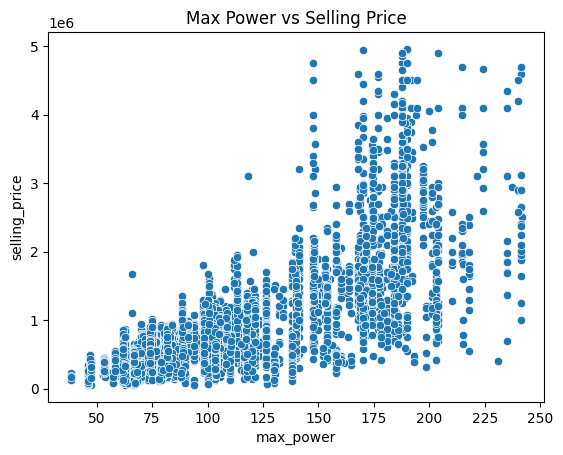

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x='max_power', y='selling_price')
plt.title("Max Power vs Selling Price")
plt.show()


In [134]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Load your dataset
df = pd.read_csv("/kaggle/input/cardekho-used-car-data/cardekho_dataset.csv")

# Drop rows with missing selling_price
df.dropna(subset=['selling_price'], inplace=True)

# Simulate predicted price (replace this with your regression model prediction)
df['predicted_price'] = df['selling_price'] * np.random.uniform(0.95, 1.05, size=len(df))

# Calculate estimated original price
depreciation_rate = 0.15
df['estimated_original_price'] = df['predicted_price'] / (1 - depreciation_rate * df['vehicle_age'])

# Create Sell (1) vs Keep (0) label
df['label'] = (df['predicted_price'] < 0.4 * df['estimated_original_price']).astype(int)

# Feature engineering
df['log_km_driven'] = np.log1p(df['km_driven'])
df['age_times_km'] = df['vehicle_age'] * df['km_driven']
df['price_per_km'] = df['predicted_price'] / (df['km_driven'] + 1)

# One-hot encoding for categorical features
df = pd.get_dummies(df, columns=['fuel_type', 'transmission_type'], drop_first=True)

# Features to use (check if they exist now)
features = [
    'vehicle_age', 'km_driven', 'log_km_driven', 'age_times_km', 'price_per_km',
    'fuel_type_Diesel', 'fuel_type_Electric', 'fuel_type_LPG', 'fuel_type_Petrol',
    'transmission_type_Manual'
]

# Some of these columns might still not exist (e.g., Electric or LPG if not present), so filter them:
available_features = [col for col in features if col in df.columns]

# Final X and y
X = df[available_features]
y = df['label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Train classifier
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluation
print("📊 Gradient Boosting Classifier Report (Sell vs Keep):\n")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


📊 Gradient Boosting Classifier Report (Sell vs Keep):

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3387
           1       1.00      0.98      0.99      1237

    accuracy                           0.99      4624
   macro avg       1.00      0.99      0.99      4624
weighted avg       0.99      0.99      0.99      4624

Confusion Matrix:
 [[3385    2]
 [  23 1214]]


In [170]:
def recommend_similar_cars(input_dict, original_df, model, trained_columns, top_n=5, price_tolerance=0.15):
    # Step 1: Preprocess input and predict price
    processed_input = preprocess_single_input(input_dict, trained_columns)
    predicted_log_price = model.predict(processed_input)[0]
    predicted_price = np.expm1(predicted_log_price)

    # Step 2: Filter by price range
    lower_price = predicted_price * (1 - price_tolerance)
    upper_price = predicted_price * (1 + price_tolerance)

    price_filtered = original_df[
        (original_df['selling_price'] >= lower_price) &
        (original_df['selling_price'] <= upper_price)
    ]

    # Step 3: Filter by main specs (brand, model, fuel, transmission)
    feature_filtered = price_filtered[
        (price_filtered['brand'] == input_dict['brand']) &
        (price_filtered['model'] == input_dict['model']) &
        (price_filtered['fuel_type_' + input_dict['fuel_type']] == 1) &
        (price_filtered['transmission_type_Manual'] == (1 if input_dict['transmission_type'] == 'Manual' else 0))
    ]

    if feature_filtered.empty:
        return predicted_price, pd.DataFrame()

    # Step 4: Format results
    recommendations = feature_filtered.copy()
    recommendations['selling_price'] = recommendations['selling_price'].apply(lambda x: f"₹{int(x):,}")
    recommendations = recommendations.rename(columns={'vehicle_age': 'age (years)'})

    # Step 5: Return top N by least km driven
    top_recommendations = recommendations.sort_values(by='km_driven').head(top_n)

    return predicted_price, top_recommendations


In [175]:
sample_input = {
    'brand': 'Maruti',
    'model': 'Baleno',
    'vehicle_age': 5,  # instead of year
    'km_driven': 40000,
    'fuel_type': 'Petrol',
    'seller_type': 'Individual',
    'transmission_type': 'Manual',  # 1 = Manual, 0 = Automatic
    'mileage': '21.4 kmpl',
    'engine': '1197 CC',
    'max_power': '81.80 bhp',
    'selling_price': 500000
}


In [176]:
predicted_price, recommendations = recommend_similar_cars(
    sample_input, df, final_model, trained_columns
)

print(f"\n💸 Predicted Price: ₹{int(predicted_price):,}")
print("\n📋 Recommended Cars:")

if recommendations.empty:
    print("😕 No similar cars found in this price range.")
else:
    print(recommendations[['age (years)', 'brand', 'model', 'km_driven', 'fuel_type_Petrol',
                           'transmission_type_Manual', 'selling_price']].to_string(index=False))



💸 Predicted Price: ₹500,226

📋 Recommended Cars:
 age (years)  brand  model  km_driven  fuel_type_Petrol  transmission_type_Manual selling_price
           1 Maruti Baleno       5000              True                      True      ₹557,000
           2 Maruti Baleno      10000              True                      True      ₹550,000
           2 Maruti Baleno      11000              True                      True      ₹535,000
           4 Maruti Baleno      13355              True                      True      ₹565,000
           5 Maruti Baleno      14500              True                      True      ₹560,000


In [177]:
import joblib
# Save the trained model
joblib.dump(model, 'car_price_model.pkl')


['car_price_model.pkl']

In [180]:
from sklearn.preprocessing import OneHotEncoder
import joblib

# Example: fitting an encoder to categorical data (during training phase)
encoder = OneHotEncoder(drop='first', sparse=False) 

# Save the encoder to a file
joblib.dump(encoder, 'encoder.pkl')


['encoder.pkl']